### Imports

In [103]:
import PIL
import glob #allows us to access every image in folder
import re #allows us to extract emotion from file path
import numpy as np

from PIL import Image #allows us to resize images/get their initial pixel value
from sklearn import preprocessing #allows us to normalize our data



# a.i

### Resizing images & Converting to np array

Start by seeing what the initial pixel size is, because we want to get it down to a 30x30 image

In [93]:
def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width, height

In [106]:
width_1_happy, height_1_happy = get_num_pixels("Images/subject01.happy.gif")

print("Width: ", width_1_happy)
print("Height: ", height_1_happy)

Width:  320
Height:  243


Now we know all images have a size of 320x243 (even when their file sizes are different)... this will NOT resize in a way that keeps the aspect ratio in tact. There is a large amount of blank space on the left of what appears to be every image, perhaps we can just shave that portion off

#### Changing the size of the images

Because we're unable to maintain ratios and shrink down to a 30x30 size, we're going to chop off some of the extra white space on the images widths. We're going to get each image down to 243x243 so when we shrink to 30x30 nothing gets stretched out of proportion

In [95]:
list_subjects = []

for subject_num in range(1,16):
    if subject_num < 10:
        list_subjects.append("subject0" + str(subject_num))
    else:
        list_subjects.append("subject" + str(subject_num))


This function takes in a list of people whose image needs to be cropped in a similar fashion, and the dimensions of their cropping.

It then crops it into a square so it can be resized into a 30x30 shape without any warping

The image is then converted into a np array of its pixel values & added to our training data set. The label for each image is also added to an array (this is in the same order as our training data)

In [111]:
def image_resize(list_subjects, left, right, top, bottom):
    subject_labels = []
    training_data = []
    
    for subject in list_subjects:
        for image_path in glob.glob("Images/" + subject + "*"):
            #for each image, extract the label
            search_string = subject + ".(.+?).gif"
            m = re.search(search_string, image_path)
            if m:
                emotion = m.group(1)
                subject_labels.append(subject + ": " + emotion)
            
            #for each image, trim off the specified edges & save to new folder
            crop_image_path = "Images_Cropped/" + subject + "." + emotion + ".gif"
            orig_image = Image.open(image_path)
            orig_image.crop((left, top, right, bottom)).save(crop_image_path)
            
            #for each cropped image, resize to 30x30
            resize_image_path = "Images_Resized/" + subject + "." + emotion + ".gif"
            basewidth = 30
            crop_image = Image.open(crop_image_path)
            wpercent = (basewidth / float(crop_image.size[0]))
            hsize = int((float(crop_image.size[1]) * float(wpercent)))
            resize_image = crop_image.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
            resize_image.save(resize_image_path)
            
            #for each resized image, convert to 1x90 np array
            image_frame = Image.open(resize_image_path)
            np_frame = np.array(image_frame.getdata()) #gets pixel values
            image_list = list(np_frame)
            training_data.append(image_list)

    return subject_labels, training_data 
        

This organizes the subjects based on their cropping dimension needs. It's kind of a hack job, but it works

In [112]:
first_list = list_subjects[0:5]

second_list = list_subjects[5:7]
second_list.append(list_subjects[13])

third_list = list_subjects[7:10]
third_list.append(list_subjects[12])
third_list.append(list_subjects[14])

fourth_list = list_subjects[10:12]

This creates an overarching list for all training data and labels, and populates it with the ouput of our image resize function

In [113]:
temp_training_data = []
temp_labels = []

first_labels, first_data = image_resize(first_list, 54, 297, 0, 243)
temp_labels.append(first_labels)
temp_training_data.append(first_data)

second_labels, second_data = image_resize(second_list, 0, 243, 0, 243)
temp_labels.append(second_labels)
temp_training_data.append(second_data)

third_labels, third_data = image_resize(third_list, 43, 286, 0, 243)
temp_labels.append(third_labels)
temp_training_data.append(third_data)

fourth_labels, fourth_data = image_resize(fourth_list, 69, 312, 0, 243)
temp_labels.append(fourth_labels)
temp_training_data.append(fourth_data)

Get rid of nested sublists and convert training data to np array

In [114]:
labels = []
for sublist in temp_labels:
    for item in sublist:
        labels.append(item)

training_data = []
for sublist in temp_training_data:
    for item in sublist:
        training_data.append(item)

training_data = np.array(training_data)

Let's verify we have 165 vectors of size 1x90 for our training data

And an array of size 65 for our labels

In [115]:
print(len(labels))
print(training_data.shape)

165
(165, 900)


Below shows how the image is now represented by numbers. You cannot see it here because each row is broken up in the middle, but if you copy and past the output below into a text file and give each row its own line you will see the outline of a face :)

In [117]:
print(str(labels[2])) #Prints letter being shown
#Reshape image to be 14x9, then loop through each new row to print
for row in training_data[2].reshape(30, 30):
    print(row)

subject01: noglasses
[213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 213
 213 213 213 213 213 213 213 213 213 213 213 213]
[213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 213
 213 213 213 213 213 213 213 213 213 213 213 213]
[213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 206 198 120
  98 113 143 213 213 213 213 213 213 213 213 213]
[213 213 213 213 213 213 213 213 213 213 213 213 213 208 139  80  64  56
  52  91 100 122 119 213 213 213 213 213 213 213]
[213 213 213 213 213 213 213 213 213 213 213 178  67 101  62  69  37  39
  81 102 105  89  78  91 213 213 213 213 213 213]
[213 213 213 213 213 213 213 213 213 213 104 120  74  74  60  66  50  30
  62  98 113  79  79 101  76 173 213 213 213 213]
[213 213 213 213 213 213 213 213 213 119 126 139 104  79  88 153 111  27
  31  83  89 110  78  71  76  70 191 213 213 213]
[213 213 213 213 213 213 213 213 129 101  84  56  80 147 144 101 112  72
  41  65  86  92  81  78  59  49  70 213 213 

### Normalized Training Data

Converts values to the range of 0:1

In [104]:
normalized_training_data = preprocessing.normalize(training_data)

In [2]:
#(a.ii) (1 point) Implement PCA on the input images. Assume that the input vector of PCA
#contains all rows of an image superimposed one after the other. You can use available libraries
#that calculate the eigenvalues and eigenvectors of a matrix. Hint: Don’t forget to normalize the
#data.


import PIL
import glob #allows us to access every image in folder
import re #allows us to extract emotion from file path
import numpy as np

from PIL import Image #allows us to resize images/get their initial pixel value
from sklearn import preprocessing #allows us to normalize our data


import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sb


def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width, height

width_1_happy, height_1_happy = get_num_pixels("Images/subject01.happy.gif")

list_subjects = []

for subject_num in range(1,16):
    if subject_num < 10:
        list_subjects.append("subject0" + str(subject_num))
    else:
        list_subjects.append("subject" + str(subject_num))
        
        
def image_resize(list_subjects, left, right, top, bottom):
    subject_labels = []
    training_data = []
    
    for subject in list_subjects:
        for image_path in glob.glob("Images/" + subject + "*"):
            #for each image, extract the label
            search_string = subject + ".(.+?).gif"
            m = re.search(search_string, image_path)
            if m:
                emotion = m.group(1)
                subject_labels.append(subject + ": " + emotion)
            
            #for each image, trim off the specified edges & save to new folder
            crop_image_path = "Images_Cropped/" + subject + "." + emotion + ".gif"
            orig_image = Image.open(image_path)
            orig_image.crop((left, top, right, bottom)).save(crop_image_path)
            
            #for each cropped image, resize to 30x30
            resize_image_path = "Images_Resized/" + subject + "." + emotion + ".gif"
            basewidth = 30
            crop_image = Image.open(crop_image_path)
            wpercent = (basewidth / float(crop_image.size[0]))
            hsize = int((float(crop_image.size[1]) * float(wpercent)))
            resize_image = crop_image.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
            resize_image.save(resize_image_path)
            
            #for each resized image, convert to 1x90 np array
            image_frame = Image.open(resize_image_path)
            np_frame = np.array(image_frame.getdata()) #gets pixel values
            image_list = list(np_frame)
            training_data.append(image_list)

    return subject_labels, training_data 

first_list = list_subjects[0:5]

second_list = list_subjects[5:7]
second_list.append(list_subjects[13])

third_list = list_subjects[7:10]
third_list.append(list_subjects[12])
third_list.append(list_subjects[14])

fourth_list = list_subjects[10:12]

temp_training_data = []
temp_labels = []

first_labels, first_data = image_resize(first_list, 54, 297, 0, 243)
temp_labels.append(first_labels)
temp_training_data.append(first_data)

second_labels, second_data = image_resize(second_list, 0, 243, 0, 243)
temp_labels.append(second_labels)
temp_training_data.append(second_data)

third_labels, third_data = image_resize(third_list, 43, 286, 0, 243)
temp_labels.append(third_labels)
temp_training_data.append(third_data)

fourth_labels, fourth_data = image_resize(fourth_list, 69, 312, 0, 243)
temp_labels.append(fourth_labels)
temp_training_data.append(fourth_data)

labels = []
for sublist in temp_labels:
    for item in sublist:
        labels.append(item)

training_data = []
for sublist in temp_training_data:
    for item in sublist:
        training_data.append(item)

training_data = np.array(training_data)

normalized_training_data = preprocessing.normalize(training_data)

n_samples = normalized_training_data.shape[0]
n_features = normalized_training_data.shape[1]
n_components = min(n_samples, n_features)

covar_matrix = PCA(n_components)
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
print("\n\nThe following eigenvectors: \n \n" , evecs)
print("\n\nThe following eigenvalues: \n \n" , evals)

plt.ylabel('% Variance Explained')
plt.xlabel('Components')
plt.title('PCA Analysis')
plt.ylim(30,100.5)

plt.plot(evals)



The following eigenvectors: 
 
 [[-1.45118580e-04  1.03429787e-02 -8.17339607e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.37995011e-04  1.09541128e-02 -7.45780260e-03 ... -6.10897680e-01
   2.85490271e-02 -6.05197814e-02]
 [ 2.39290823e-04  1.02397754e-02 -7.30160889e-03 ...  1.55159988e-01
  -5.78622232e-01 -1.46022798e-01]
 ...
 [ 3.63209264e-02 -5.87072071e-02  1.50103429e-02 ...  3.03765716e-02
  -3.37894610e-02 -7.79432065e-03]
 [ 3.63595230e-02 -6.42387964e-02  9.26253333e-03 ... -4.79739417e-02
  -2.52956379e-02 -2.72502280e-02]
 [ 3.78813071e-02 -5.60804723e-02 -3.47655738e-04 ...  6.34700386e-03
   2.68677852e-02 -2.17978150e-02]]


The following eigenvalues: 
 
 [-1.01890105e-17 -5.62337172e-18 -3.93469296e-18 -3.08920239e-18
 -2.68114657e-18 -2.54426988e-18 -2.51207510e-18 -2.25598357e-18
 -2.02201394e-18 -1.72729477e-18 -1.66333384e-18 -1.64152804e-18
 -1.50716215e-18 -1.50635011e-18 -1.41677941e-18 -1.41240809e-18
 -1.40085131e-18 -1.37474751e-18 -1.3

The number of components we need to capture 99% of the energy is 165


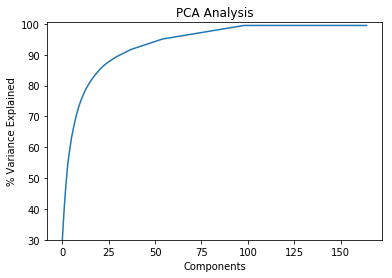

In [44]:
#(a.iii) (0.5 points) Plot a curve displaying the first k eigenvalues λ1, . . . , λK, i.e. the energy
#of the first K principal components. How many components do we need to capture 99% of the
#energy?

import PIL
import glob #allows us to access every image in folder
import re #allows us to extract emotion from file path
import numpy as np

from PIL import Image #allows us to resize images/get their initial pixel value
from sklearn import preprocessing #allows us to normalize our data


import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sb


def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width, height

width_1_happy, height_1_happy = get_num_pixels("Images/subject01.happy.gif")

list_subjects = []

for subject_num in range(1,16):
    if subject_num < 10:
        list_subjects.append("subject0" + str(subject_num))
    else:
        list_subjects.append("subject" + str(subject_num))
        
        
def image_resize(list_subjects, left, right, top, bottom):
    subject_labels = []
    training_data = []
    
    for subject in list_subjects:
        for image_path in glob.glob("Images/" + subject + "*"):
            #for each image, extract the label
            search_string = subject + ".(.+?).gif"
            m = re.search(search_string, image_path)
            if m:
                emotion = m.group(1)
                subject_labels.append(subject + ": " + emotion)
            
            #for each image, trim off the specified edges & save to new folder
            crop_image_path = "Images_Cropped/" + subject + "." + emotion + ".gif"
            orig_image = Image.open(image_path)
            orig_image.crop((left, top, right, bottom)).save(crop_image_path)
            
            #for each cropped image, resize to 30x30
            resize_image_path = "Images_Resized/" + subject + "." + emotion + ".gif"
            basewidth = 30
            crop_image = Image.open(crop_image_path)
            wpercent = (basewidth / float(crop_image.size[0]))
            hsize = int((float(crop_image.size[1]) * float(wpercent)))
            resize_image = crop_image.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
            resize_image.save(resize_image_path)
            
            #for each resized image, convert to 1x90 np array
            image_frame = Image.open(resize_image_path)
            np_frame = np.array(image_frame.getdata()) #gets pixel values
            image_list = list(np_frame)
            training_data.append(image_list)

    return subject_labels, training_data 

first_list = list_subjects[0:5]

second_list = list_subjects[5:7]
second_list.append(list_subjects[13])

third_list = list_subjects[7:10]
third_list.append(list_subjects[12])
third_list.append(list_subjects[14])

fourth_list = list_subjects[10:12]

temp_training_data = []
temp_labels = []

first_labels, first_data = image_resize(first_list, 54, 297, 0, 243)
temp_labels.append(first_labels)
temp_training_data.append(first_data)

second_labels, second_data = image_resize(second_list, 0, 243, 0, 243)
temp_labels.append(second_labels)
temp_training_data.append(second_data)

third_labels, third_data = image_resize(third_list, 43, 286, 0, 243)
temp_labels.append(third_labels)
temp_training_data.append(third_data)

fourth_labels, fourth_data = image_resize(fourth_list, 69, 312, 0, 243)
temp_labels.append(fourth_labels)
temp_training_data.append(fourth_data)

labels = []
for sublist in temp_labels:
    for item in sublist:
        labels.append(item)

training_data = []
for sublist in temp_training_data:
    for item in sublist:
        training_data.append(item)

training_data = np.array(training_data)

normalized_training_data = preprocessing.normalize(training_data)

n_samples = normalized_training_data.shape[0]
n_features = normalized_training_data.shape[1]
n_components = min(n_samples, n_features)

covar_matrix = PCA(n_components) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print(var)

plt.ylabel('% Variance Explained')
plt.xlabel('Components')
plt.title('PCA Analysis')
plt.ylim(30,100.5)

plt.plot(var)

print("The number of components we need to capture 99% of the energy is", n_components)

In [8]:
#(a.iv) (0.5 points) Plot the top 10 eigenfaces, i.e. the eigenvectors uk, k = 1, . . . , 10 obtained
#by the PCA

import PIL
import glob #allows us to access every image in folder
import re #allows us to extract emotion from file path
import numpy as np

from PIL import Image #allows us to resize images/get their initial pixel value
from sklearn import preprocessing #allows us to normalize our data


import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sb


def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width, height

width_1_happy, height_1_happy = get_num_pixels("Images/subject01.happy.gif")

list_subjects = []

for subject_num in range(1,16):
    if subject_num < 10:
        list_subjects.append("subject0" + str(subject_num))
    else:
        list_subjects.append("subject" + str(subject_num))
        
        
def image_resize(list_subjects, left, right, top, bottom):
    subject_labels = []
    training_data = []
    
    for subject in list_subjects:
        for image_path in glob.glob("Images/" + subject + "*"):
            #for each image, extract the label
            search_string = subject + ".(.+?).gif"
            m = re.search(search_string, image_path)
            if m:
                emotion = m.group(1)
                subject_labels.append(subject + ": " + emotion)
            
            #for each image, trim off the specified edges & save to new folder
            crop_image_path = "Images_Cropped/" + subject + "." + emotion + ".gif"
            orig_image = Image.open(image_path)
            orig_image.crop((left, top, right, bottom)).save(crop_image_path)
            
            #for each cropped image, resize to 30x30
            resize_image_path = "Images_Resized/" + subject + "." + emotion + ".gif"
            basewidth = 30
            crop_image = Image.open(crop_image_path)
            wpercent = (basewidth / float(crop_image.size[0]))
            hsize = int((float(crop_image.size[1]) * float(wpercent)))
            resize_image = crop_image.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
            resize_image.save(resize_image_path)
            
            #for each resized image, convert to 1x90 np array
            image_frame = Image.open(resize_image_path)
            np_frame = np.array(image_frame.getdata()) #gets pixel values
            image_list = list(np_frame)
            training_data.append(image_list)

    return subject_labels, training_data 

first_list = list_subjects[0:5]

second_list = list_subjects[5:7]
second_list.append(list_subjects[13])

third_list = list_subjects[7:10]
third_list.append(list_subjects[12])
third_list.append(list_subjects[14])

fourth_list = list_subjects[10:12]

temp_training_data = []
temp_labels = []

first_labels, first_data = image_resize(first_list, 54, 297, 0, 243)
temp_labels.append(first_labels)
temp_training_data.append(first_data)

second_labels, second_data = image_resize(second_list, 0, 243, 0, 243)
temp_labels.append(second_labels)
temp_training_data.append(second_data)

third_labels, third_data = image_resize(third_list, 43, 286, 0, 243)
temp_labels.append(third_labels)
temp_training_data.append(third_data)

fourth_labels, fourth_data = image_resize(fourth_list, 69, 312, 0, 243)
temp_labels.append(fourth_labels)
temp_training_data.append(fourth_data)

labels = []
for sublist in temp_labels:
    for item in sublist:
        labels.append(item)

training_data = []
for sublist in temp_training_data:
    for item in sublist:
        training_data.append(item)

training_data = np.array(training_data)

normalized_training_data = preprocessing.normalize(training_data)

n_samples = normalized_training_data.shape[0]
n_features = normalized_training_data.shape[1]
n_components = min(n_samples, n_features)

covar_matrix = PCA(n_components)
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

In [9]:
print(evecs.shape)
print(cov_mat.shape)

(900, 900)
(900, 900)


(900,)
(900,)
(900,)
(900,)
(900,)
(900,)
(900,)
(900,)
(900,)
(900,)


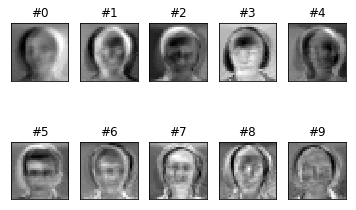

In [13]:
def plot_eigenfaces(images, h, w, rows=2, cols=5):
    plt.figure()
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        
        print(images[:,i].shape)
        plt.imshow(images[:,i].reshape((h,w)), cmap=plt.cm.gray)
        plt.title("#{}".format(i))
        plt.xticks(())
        plt.yticks(())

evecs_fixed = (np.round(evecs, decimals=3)*100)

plot_eigenfaces(evecs_fixed[:,:10], 30, 30)

# print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
# #print("\n\nThe following eigenvalues: \n \n" , evals)

# plt.ylabel('Eigenvectors')
# plt.xlabel('u_k')
# plt.title('Eigenvectors Plot')
# plt.xlim([0, 10])

# evecs_plot = plt.plot(evecs_fixed)

In [35]:
X = training_data
X_mean = np.mean(X, axis=0).reshape(1,900)
print(X.shape)
print(X_mean.shape)
print(numpy.matlib.repmat(X_mean,X.shape[0],1).shape)
import numpy.matlib

(165, 900)
(1, 900)
(165, 900)


In [37]:
X_norm = X-numpy.matlib.repmat(X_mean, X.shape[0], 1)

In [47]:
n_samples = X_norm.shape[0]
n_features = X_norm.shape[1]
#n_components = min(n_samples, n_features)

#covar_matrix = PCA(n_components)
#covar_matrix.fit(X_norm)
#variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

#var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(X_norm, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
#evecs_fixed = (np.round(evecs, decimals=3)*100)

#plot_eigenfaces(evecs_fixed[:,:10], 30, 30)

(1, 900)
(900, 50)
(50,)
(1, 900)


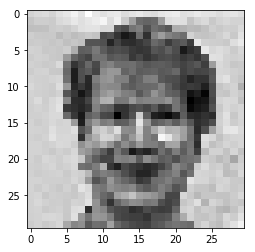

In [50]:
x=np.asarray(Image.open("Images_Resized/subject01.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:50]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(50):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 50)
(50,)
(1, 900)


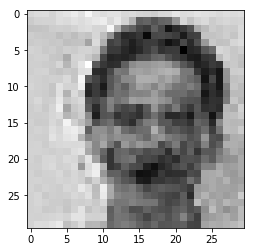

In [54]:
x=np.asarray(Image.open("Images_Resized/subject02.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:50]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(50):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 40)
(40,)
(1, 900)


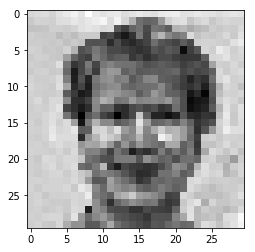

In [56]:
x=np.asarray(Image.open("Images_Resized/subject01.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:40]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(40):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 30)
(30,)
(1, 900)


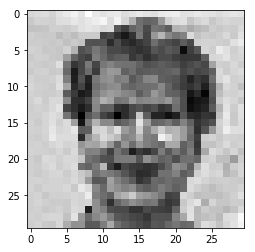

In [57]:
x=np.asarray(Image.open("Images_Resized/subject01.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:30]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(30):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 20)
(20,)
(1, 900)


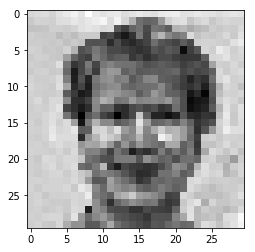

In [58]:
x=np.asarray(Image.open("Images_Resized/subject01.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:20]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(20):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 10)
(10,)
(1, 900)


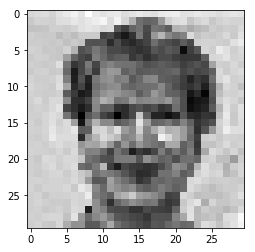

In [59]:
x=np.asarray(Image.open("Images_Resized/subject01.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:10]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(10):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 40)
(40,)
(1, 900)


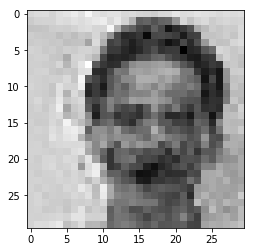

In [60]:
x=np.asarray(Image.open("Images_Resized/subject02.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:40]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(40):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 30)
(30,)
(1, 900)


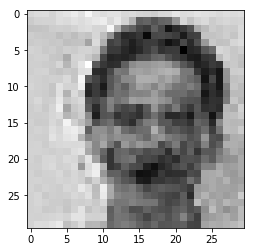

In [61]:
x=np.asarray(Image.open("Images_Resized/subject02.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:30]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(30):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 20)
(20,)
(1, 900)


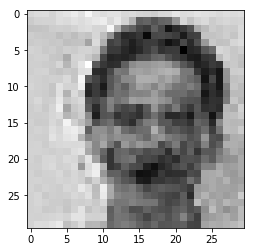

In [62]:
x=np.asarray(Image.open("Images_Resized/subject02.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:20]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(20):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 10)
(10,)
(1, 900)


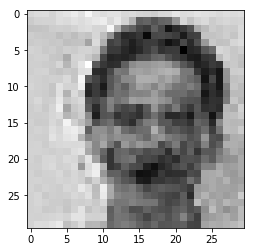

In [63]:
x=np.asarray(Image.open("Images_Resized/subject02.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:10]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(10):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

In [64]:
x=np.asarray(Image.open("Images_Resized/subject01.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:1]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(1):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 1)
()


IndexError: too many indices for array

In [65]:
x=np.asarray(Image.open("Images_Resized/subject02.happy.gif")).reshape((1,900))
x=x-X_mean.reshape((1,900))
print(x.shape)
U=evecs[:,:1]
print(U.shape)
C=np.squeeze(np.matmul(x,U))
#print(C)
print(C.shape)
x_hat = X_mean
for i in range(1):
    x_hat += C[i]*U[:,i]
#     print(U[:,i])
#     print(C[i])
#     print(C[i]*U[:,i])
print(x_hat.shape)
#print(x_hat)
plt.imshow(np.reshape(x_hat, (30, 30)), cmap=plt.cm.gray)

(1, 900)
(900, 1)
()


IndexError: too many indices for array

In [82]:
#(a.v) (0.5 points) Select a couple of images from the data. Use the first k eigenfaces as a
#basis to reconstruct the images. Visualize the reconstructed images using 1, 10, 20, 30, 40, 50
#components. How many components do we need to achieve a visually good result?
#Hint: Reconstruction of an input vector x based on the eigenvectors u1, . . . , uK is given by the
#following expression ˆx = x0 +, where x is the projection of the input image to the k
#the eigenvector and x0 is the mean value of all vectors.


#========================================num_components = 1 with subject 4

width_1_happy, height_1_happy = get_num_pixels("Images/subject04.happy.gif")

normalized_training_data = preprocessing.normalize(training_data)

n_samples = normalized_training_data.shape[0]
n_features = normalized_training_data.shape[1]
n_components = min(n_samples, n_features)

covar_matrix = PCA(n_components = 1)
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)



The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [81]:
#a.v cont. ========================================num_components = 10 with subject 4
width_1_happy, height_1_happy = get_num_pixels("Images/subject04.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 10) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [78]:
#a.v cont. ========================================num_components = 20 with subject 4
width_1_happy, height_1_happy = get_num_pixels("Images/subject04.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 20)
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)



The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [77]:
#a.v cont. ========================================num_components = 30 with subject 4
width_1_happy, height_1_happy = get_num_pixels("Images/subject04.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 30)
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)



The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [79]:
#a.v cont. ========================================num_components = 40 with subject 4
width_1_happy, height_1_happy = get_num_pixels("Images/subject04.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 40) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [80]:
#a.v cont. ========================================num_components = 50 with subject 4
width_1_happy, height_1_happy = get_num_pixels("Images/subject04.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 50) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [89]:
#a.v cont. ========================================num_components = 1 with subject 5
width_1_happy, height_1_happy = get_num_pixels("Images/subject05.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 1) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [88]:
#a.v cont. ========================================num_components = 10 with subject 5
width_1_happy, height_1_happy = get_num_pixels("Images/subject05.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 10) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [83]:
#a.v cont. ========================================num_components = 20 with subject 5
width_1_happy, height_1_happy = get_num_pixels("Images/subject05.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 20) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [87]:
#a.v cont. ========================================num_components = 30 with subject 5
width_1_happy, height_1_happy = get_num_pixels("Images/subject05.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 30) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [86]:
#a.v cont. ========================================num_components = 40 with subject 5
width_1_happy, height_1_happy = get_num_pixels("Images/subject05.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 40) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]


In [85]:
#a.v cont. ========================================num_components = 50 with subject 5
width_1_happy, height_1_happy = get_num_pixels("Images/subject05.happy.gif")
normalized_training_data = preprocessing.normalize(training_data)

covar_matrix = PCA(n_components = 50) 
covar_matrix.fit(normalized_training_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
#print(variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features
#print("The following eigenvalues: \n \n" , var)


cov_mat=np.cov(normalized_training_data, rowvar=False)
evals, evecs = np.linalg.eigh(cov_mat)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

evecs_fixed = (np.round(evecs, decimals=3)*100)

print("\n\nThe following eigenvectors: \n \n" , evecs_fixed)
#print("\n\nThe following eigenvalues: \n \n" , evals)




The following eigenvectors: 
 
 [[  0.    1.   -0.8 ...   0.    0.    0. ]
 [  0.    1.1  -0.7 ... -61.1   2.9  -6.1]
 [  0.    1.   -0.7 ...  15.5 -57.9 -14.6]
 ...
 [  3.6  -5.9   1.5 ...   3.   -3.4  -0.8]
 [  3.6  -6.4   0.9 ...  -4.8  -2.5  -2.7]
 [  3.8  -5.6   0.  ...   0.6   2.7  -2.2]]
